# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import smoothing_particles as sp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

ordering = True
video_name = "2n_2m_0f_240214_1"
n_particles = int(video_name[0])
save_figures = True
x_bounds = [0, 1080]
y_bounds = [60, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Load tracked data

In [3]:
df_tracked = pd.read_csv("{}/clustered_{}.csv".format(output_path, video_name), low_memory=False)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,658.013667,89.169044,665.626398,90.391465,0.0,667.000000,43.000000,0.631373,573.000000,118.000000,1.427848,15073.0,242.545246,96.323261,0.917760,2,NaN,NaN,NaN,NaN,False,False,False
1,1,0,1457.736234,652.648191,1445.808666,660.305997,NaN,1457.736234,652.648191,NaN,1457.736234,652.648191,0.903196,13766.0,252.641976,87.712674,0.937798,2,NaN,NaN,NaN,NaN,False,False,False


In [4]:
df_tracked.tail(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
71822,0,110883,75.912503,151.468381,78.068168,163.351742,NaN,75.912503,151.468381,NaN,75.912503,151.468381,0.131608,9646.0,222.892761,84.162919,0.925971,2,3.0,-0.168006,-0.244173,-0.002827,False,False,False
71823,1,110883,1513.427917,111.370441,1508.913934,113.709279,NaN,1513.427917,111.370441,NaN,1513.427917,111.370441,-1.489936,10474.0,179.307856,83.809174,0.884044,2,3.0,0.003368,-0.005099,-0.000205,False,False,False


## Swapping mixed IDs

In [5]:
omega_threshold = 20 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 83  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

from importlib import reload
reload(sp)

arg_list = [
    # VIDEO 1
    [0    , 10000, velocity_threshold, omega_threshold, True],
    [10000, 20000, velocity_threshold, omega_threshold, True],
    [20000, 30000, velocity_threshold, omega_threshold, True],
    [30000, 40000, velocity_threshold, omega_threshold, True],
    [40000, 50000, velocity_threshold, omega_threshold, True],
    [50000, 60000, velocity_threshold, omega_threshold, True],
    [60000, 70000, velocity_threshold, omega_threshold, True],
    [70000, 80000, velocity_threshold, omega_threshold, True],
    [80000, 90000, velocity_threshold, omega_threshold, True],
    [90000, 100000, velocity_threshold, omega_threshold, True],
    [100000, 110884, velocity_threshold, omega_threshold, True]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 83 
	- Angle: 20.0 



100%|███████████████████████| 11/11 [00:19<00:00,  1.77s/it]


Time: 30000 Chunks 2 Allowed time 30000 Permutation [0 1]
Time: 60000 Chunks 2 Allowed time 60000 Permutation [0 1]
Time: 90000 Chunks 2 Allowed time 90000 Permutation [0 1]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_10000,0,0,658.013667,89.169044,665.626398,90.391465,0.0,667.000000,43.000000,0.631373,573.000000,118.000000,1.427848,1.427848,15073.0,242.545246,96.323261,0.917760,2,NaN,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_10000,1,1,1457.736234,652.648191,1445.808666,660.305997,NaN,1457.736234,652.648191,NaN,1457.736234,652.648191,0.903196,0.903196,13766.0,252.641976,87.712674,0.937798,2,NaN,NaN,NaN,NaN,False,False,False
2,True,3,chunk_00000_10000,0,0,657.981760,89.167903,665.724815,90.386978,0.0,668.000000,43.000000,0.670588,670.000000,121.000000,-1.428990,-1.428990,14967.0,242.593095,96.150788,0.918101,2,3.0,-0.010636,-0.000380,-0.000381,False,False,False
3,True,3,chunk_00000_10000,1,1,1464.218260,648.672042,1453.500548,655.885616,NaN,1464.218260,648.672042,NaN,1464.218260,648.672042,-0.891433,-0.891433,13209.0,248.210183,86.275205,0.937647,2,3.0,2.160675,-1.325383,0.003921,True,False,False
4,True,6,chunk_00000_10000,0,0,657.649442,89.198293,665.302226,90.474820,0.0,668.000000,43.000000,0.709804,734.000000,118.000000,-1.430973,-1.430973,14882.0,241.613159,95.987414,0.917699,2,3.0,-0.110773,0.010130,-0.000661,False,False,False
5,True,6,chunk_00000_10000,1,1,1470.228406,645.297105,1458.847168,652.669749,NaN,1470.228406,645.297105,NaN,1470.228406,645.297105,-0.937379,-0.937379,12955.0,252.659470,87.011360,0.938830,2,3.0,2.003382,-1.124979,-0.015315,True,False,False
6,True,9,chunk_00000_10000,0,0,657.639790,89.164617,665.247539,90.421599,0.0,668.000000,43.000000,0.717647,718.000000,118.000000,-1.430052,-1.430052,14883.0,241.765212,95.829254,0.918089,2,3.0,-0.003217,-0.011225,0.000307,False,False,False
7,True,9,chunk_00000_10000,1,1,1479.317383,637.537812,1467.290199,644.804019,NaN,1479.317383,637.537812,NaN,1479.317383,637.537812,-1.041135,-1.041135,11954.0,246.457958,88.451845,0.933379,2,3.0,3.029659,-2.586431,-0.034585,True,False,False


In [6]:
df_final.tail(5)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
71819,True,110877,chunk_100000_110884,1,1,1513.815532,111.322244,1509.785933,113.600673,0.0,1505.000000,68.000000,0.466667,1416.000000,119.000000,-1.491863,-1.491863,10430.0,177.662847,83.937407,0.881356,2,3.0,-0.011556,0.007836,0.000146,False,False,False
71820,True,110880,chunk_100000_110884,0,0,76.416522,152.200900,79.117967,164.572932,NaN,76.416522,152.200900,NaN,76.416522,152.200900,0.140089,0.140089,9781.0,223.387047,85.323269,0.924182,2,3.0,0.171522,0.194315,0.002980,False,False,False
71821,True,110880,chunk_100000_110884,1,1,1513.417812,111.385739,1508.894950,113.729873,NaN,1513.417812,111.385739,NaN,1513.417812,111.385739,-1.489321,-1.489321,10476.0,179.380906,83.802075,0.884165,2,3.0,-0.132573,0.021165,0.000847,False,False,False
71822,True,110883,chunk_100000_110884,0,0,75.912503,151.468381,78.068168,163.351742,NaN,75.912503,151.468381,NaN,75.912503,151.468381,0.131608,0.131608,9646.0,222.892761,84.162919,0.925971,2,3.0,-0.168006,-0.244173,-0.002827,False,False,False
71823,True,110883,chunk_100000_110884,1,1,1513.427917,111.370441,1508.913934,113.709279,NaN,1513.427917,111.370441,NaN,1513.427917,111.370441,-1.489936,-1.489936,10474.0,179.307856,83.809174,0.884044,2,3.0,0.003368,-0.005099,-0.000205,False,False,False


## Interpolation over not allowed frames

In [7]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:,"permuted_id"]==df_full["permuted_id"].unique()[id_]
        df_full[mask]=df_full[mask].interpolate(method="linear")

In [8]:
if ordering:
    cols = [
        "id", "permuted_id", "time", "position_x", "position_y", "weighted_x", "weighted_y",
        "darkest_v", "darkest_x", "darkest_y", "lightest_v", "lightest_x", "lightest_y",
        "orientation", "corrected_orientation", "area", "axis_major", "axis_minor", "eccentricity"
    ]
    df_temp = df_full[cols]
    df_temp.to_csv("{}/interpolated_{}.csv".format(output_path, video_name), index=False)
    df_temp

Thresholds:
	- Velocity: 32.395439995733504 
	- Angle: 9.99031913819475 



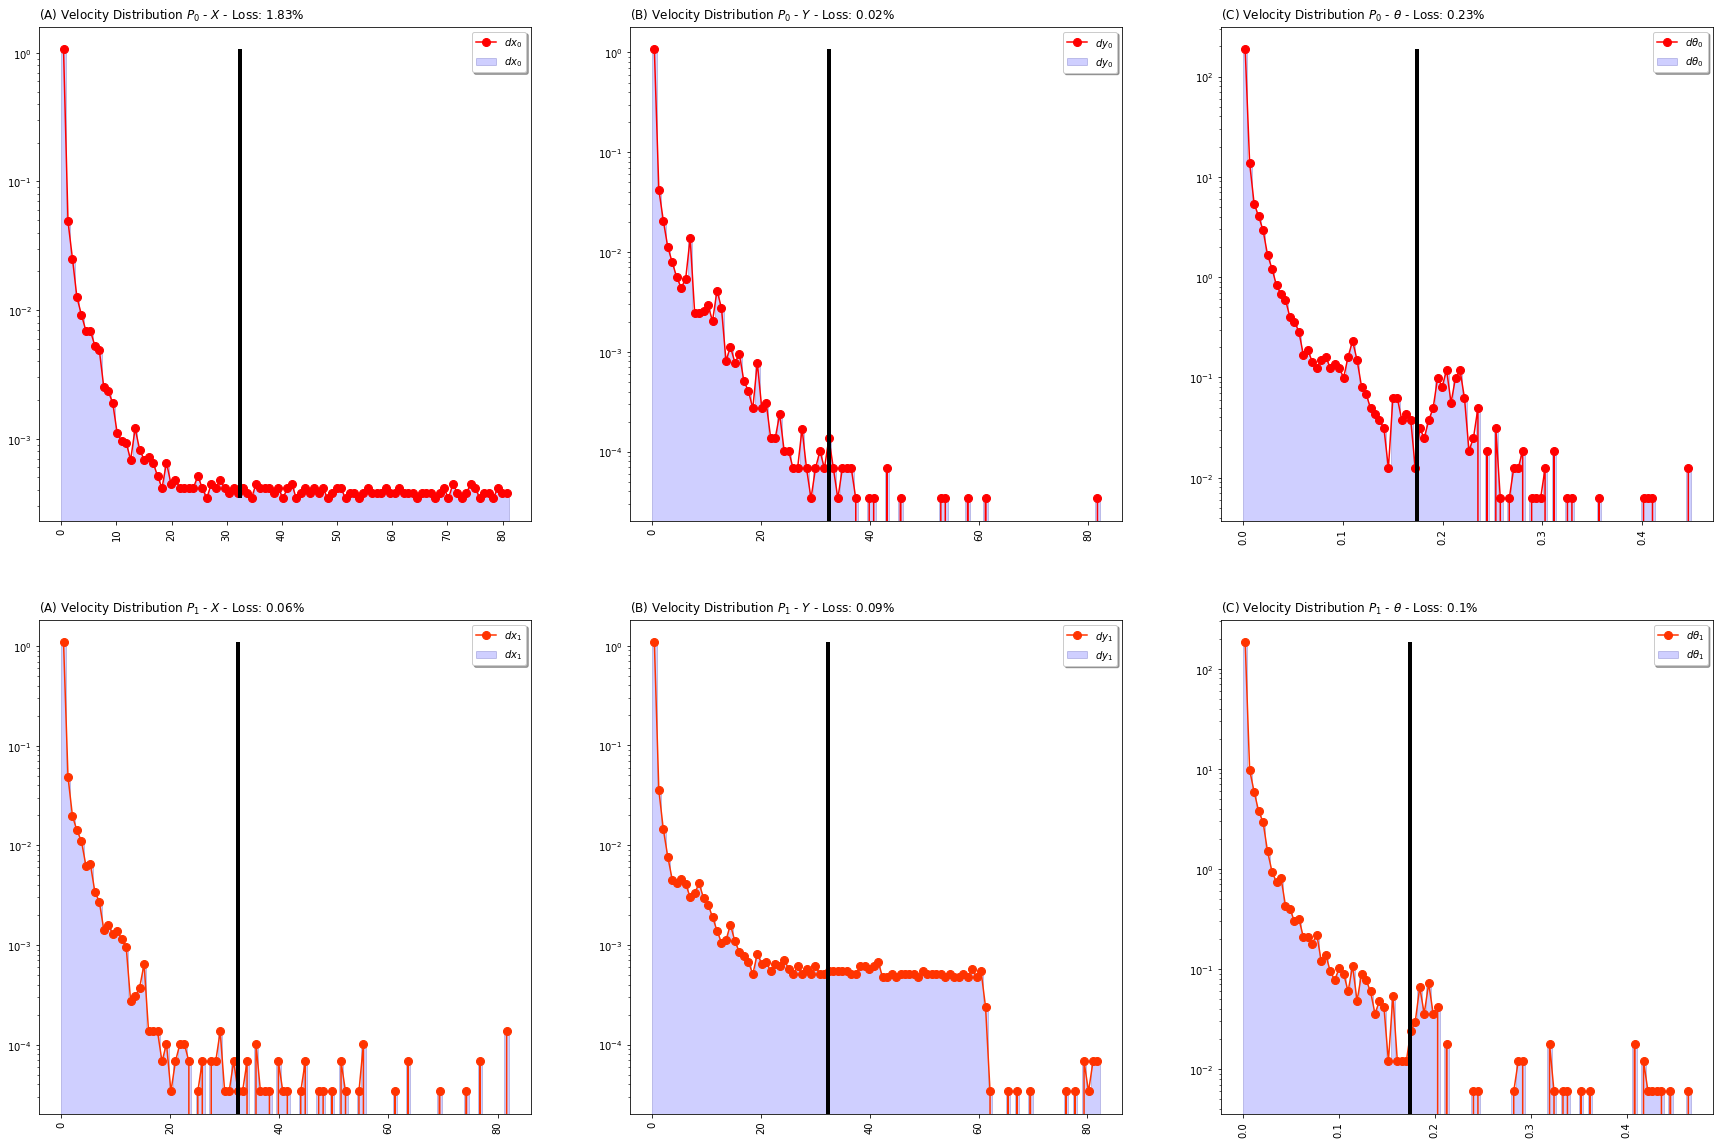

In [9]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = df_full["velocity_orientation"].abs().quantile(0.9965) # Angular velocity per frame
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9901) # Velocity per frame limited with half average size of particle
    print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend
    )

Original


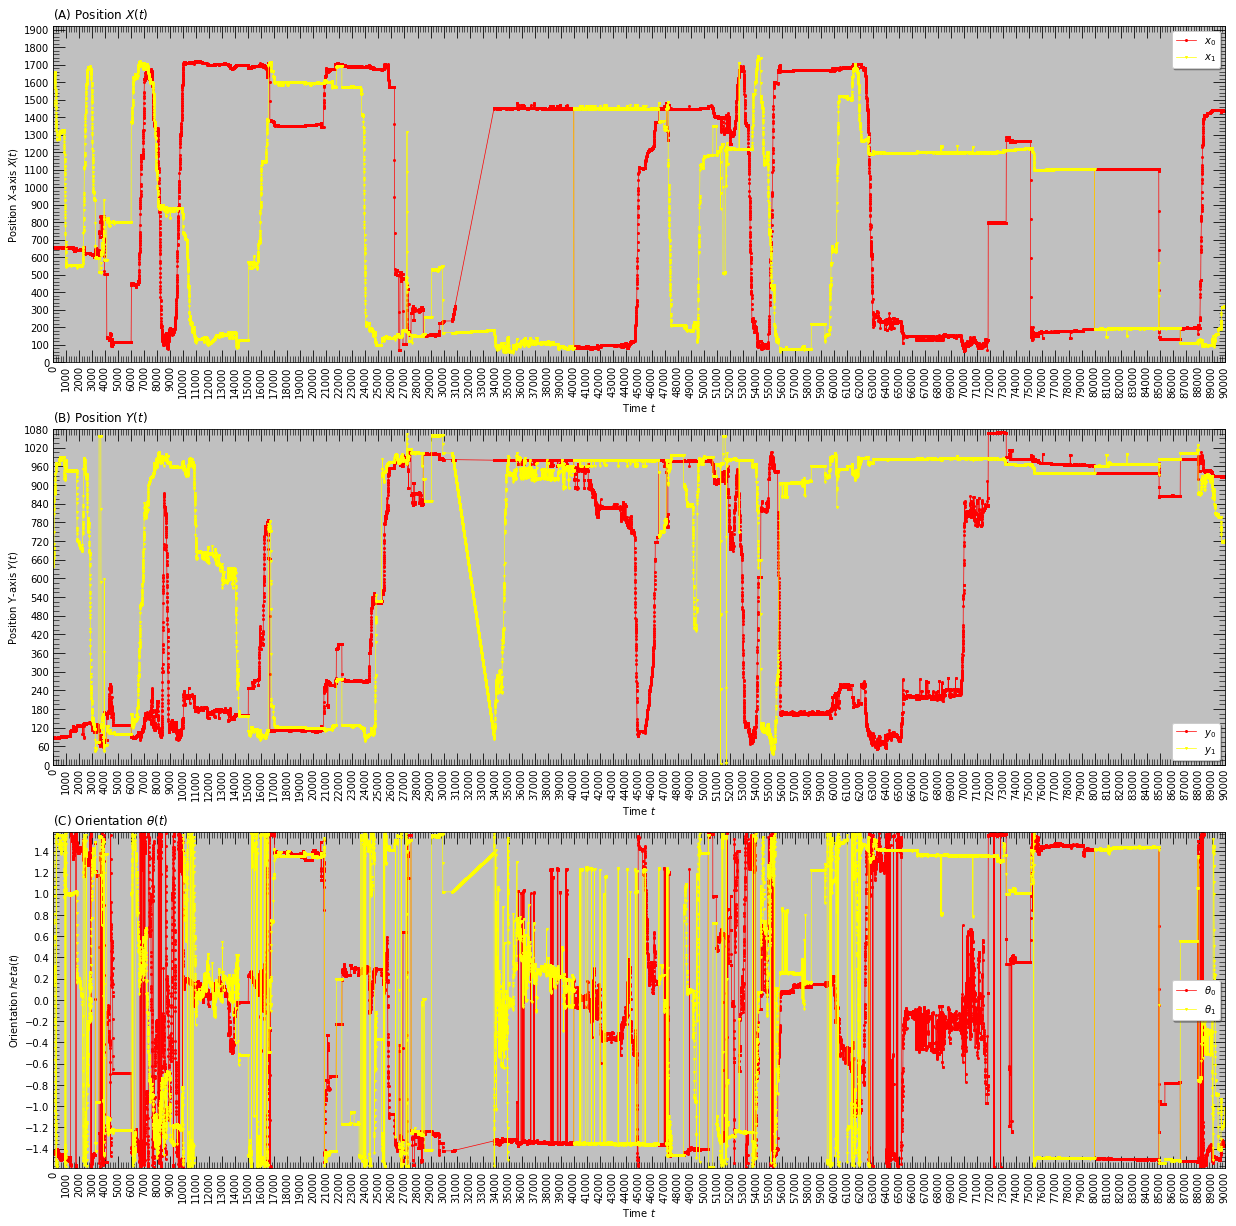

Corrected Orientation


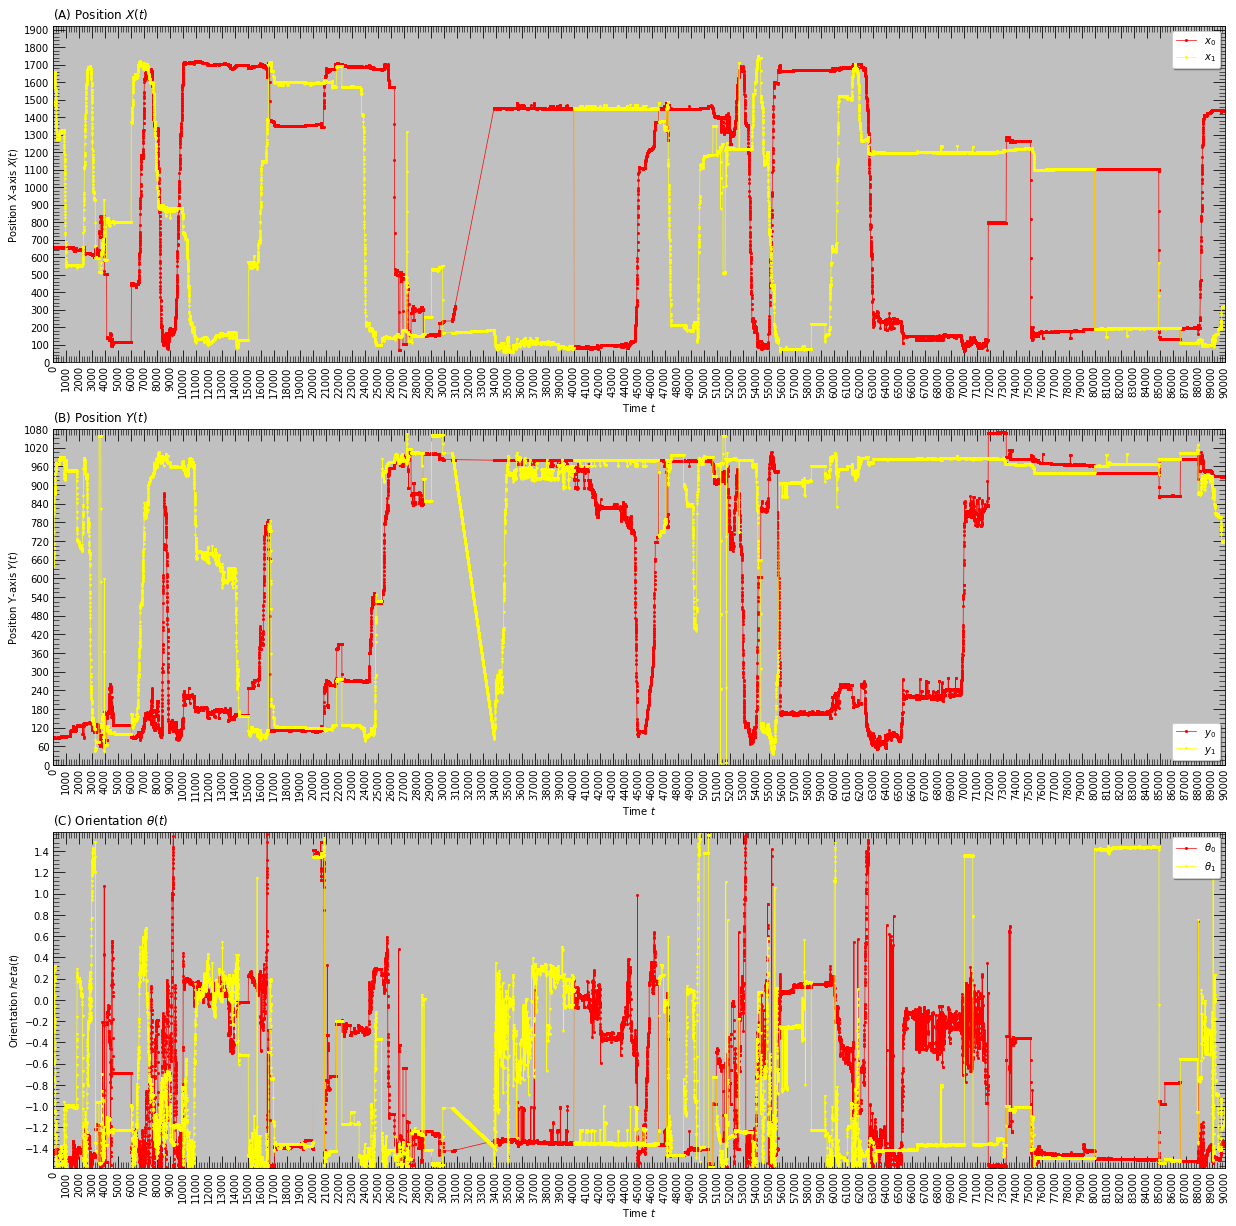

In [10]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf   = 0, 90000  # 22200, 24300
    t0_, tf_ = 0, 90000  # 22200, 24300
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1920], [0, 1080], [-1.58, 1.58]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

## Setting video information

In [11]:
# # Load the video
# reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# # Check the number of frames
# num_frames = reader.count_frames()
# print("Total frames: {}".format(num_frames))

# # Extract a frame to inspect the content
# time = 0
# frame = reader.get_data(time)
# print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

## Comparative of process

In [12]:
# # Original frame
# time = 209  #271  # 209  # 80
# times = [time - 1, time, time + 1]
# reinforce_boundaries = True
# remove_holes = False
# type = "local equalized"
# clip_limit = 0.05
# threshold = 0.19
# sigma = 1.5
# x_bounds = x_bounds  # [40, 1020]
# y_bounds = y_bounds  # [160, 1740]
# region_area_min = 200
# axis_major_min = 94
# eccentricity_max = 0.99


# df_tracked_frame_0 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[0], reader.get_data(times[0])]
# )

# df_tracked_frame_1 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[1], reader.get_data(times[1])]
# )

# df_tracked_frame_2 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[2], reader.get_data(times[2])]
# )

# df_tracked_old = pd.concat([df_tracked_frame_0, df_tracked_frame_1, df_tracked_frame_2], ignore_index=True)

# width = 10
# n_x_breaks = 20
# n_y_breaks = 20
# fancy_legend = True
# x_legend = 1.001
# y_legend = 0.891

# df_smooth = df_full.copy()
# df_smooth["id"] = df_smooth["permuted_id"]
# df_smooth["orientation"] = df_smooth["corrected_orientation"]

# fig = plt_sp.plot_all_process_frame(
#     reader=reader,
#     times=times,
#     df_tracked=df_tracked_old,
#     df_clustered=df_tracked,
#     df_smoothed=df_smooth,
#     width=width,
#     n_x_breaks=n_x_breaks,
#     n_y_breaks=n_y_breaks,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     fancy_legend=fancy_legend,
#     x_legend=x_legend,
#     y_legend=y_legend
# )